In [46]:
#Import Packages
#Requires Python 3.10 or earlier
import py_wake
import numpy as np
import matplotlib.pyplot as plt
import math

from py_wake import NOJ

#Define Situation
shore_point_longLat = [(-2.190087, 56.976389)] #Shore point longatude, Latitude

num_turb_per_row = [8,7,4,1] # Number of turbines on each row


<xarray.DataArray (sector: 12)> Size: 96B
array([0.06, 0.04, 0.04, 0.04, 0.05, 0.08, 0.12, 0.17, 0.18, 0.06, 0.06,
       0.1 ])
Coordinates:
  * sector   (sector) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

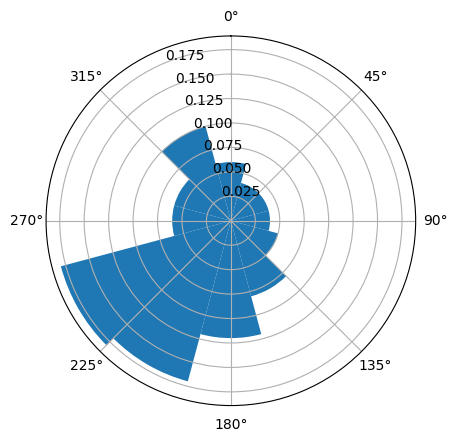

In [47]:
#Define Site
from py_wake.site import UniformWeibullSite
# Dummy offshore site object
wd = np.arange(0, 360, 30)
A = np.full_like(wd, 9.5, dtype=float) # Weibull scale parameter
k = np.full_like(wd, 2.0, dtype=float) # Weibull shape parameter

p_wd = np.array([0.06, 0.04, 0.04, 0.04, 0.05, 0.08, 0.12, 0.17, 0.18, 0.06, 0.06, 0.1], dtype=float) # sector frequencies (defines wind direction)
p_wd /= p_wd.sum()

site = UniformWeibullSite(p_wd=p_wd, a=A, k=k, ti=0.08) # Create uniform weibull site
site.plot_wd_distribution(n_wd=12) # Plot wind rose

****Wind turbine specifications****

Power and Thrust coefficient (Ct) curves:


"\nwt = WindTurbine(name='MyWT',\n                    diameter=124,\n                    hub_height=320,\n                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))\n\nor \n\nwt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)\n\nSource: https://www.pythonpool.com/pywake-library/\n"

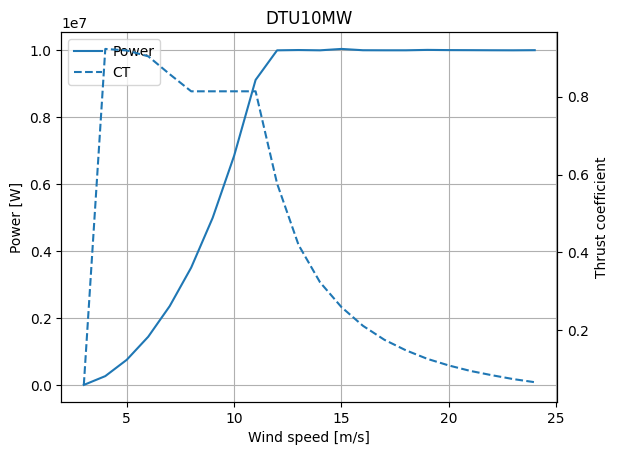

In [48]:
#Define Turbine
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import numpy as np

diameter = 200 #Turbine blade diameter in m
hub_height = 127 #Hub height in m

wt = DTU10MW() #Example 10mw turbine https://backend.orbit.dtu.dk/ws/portalfiles/portal/55645274/The_DTU_10MW_Reference_Turbine_Christian_Bak.pdf

#Plot Data
print('****Wind turbine specifications****\n')
print("Power and Thrust coefficient (Ct) curves:")
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
wt.plot_power_ct(ws=ws)

'''
wt = WindTurbine(name='MyWT',
                    diameter=124,
                    hub_height=320,
                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))

or 

wt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)

Source: https://www.pythonpool.com/pywake-library/
'''

In [49]:
#Define Turbine layout

# number of turbines in each direction:
#n_x = 5
#n_y = 4
#total_turbine = 20

rotor_diameter = diameter
dist_x = 4 * rotor_diameter
dist_y = 8 * rotor_diameter

wt_x = np.empty(0)
for row in range(len(num_turb_per_row)):
    for turbine in range(num_turb_per_row[row]):
        wt_x = np.append(wt_x,turbine*dist_x)

#Offset wind turbines by X m
x_offset = 1000
wt_x = wt_x + x_offset

wt_y= np.empty(0)
for row in range(len(num_turb_per_row)):
    for turbine in range(num_turb_per_row[row]):
        wt_y = np.append(wt_y,row*dist_y)

#Offset wind turbines by Y m
y_offset = 100
wt_y = wt_y + y_offset

wt_x = wt_x.flatten()
wt_y = wt_y.flatten()

print(wt_x, wt_y)

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

n_wt = sum(num_turb_per_row)


[1000. 1800. 2600. 3400. 4200. 5000. 5800. 6600. 1000. 1800. 2600. 3400.
 4200. 5000. 5800. 1000. 1800. 2600. 3400. 1000.] [ 100.  100.  100.  100.  100.  100.  100.  100. 1700. 1700. 1700. 1700.
 1700. 1700. 1700. 3300. 3300. 3300. 3300. 4900.]


In [50]:
#Define Engineering windfarm model
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModel = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

Total AEP: 755.929380 GWh


Text(0.5, 1.0, 'AEP vs wind direction')

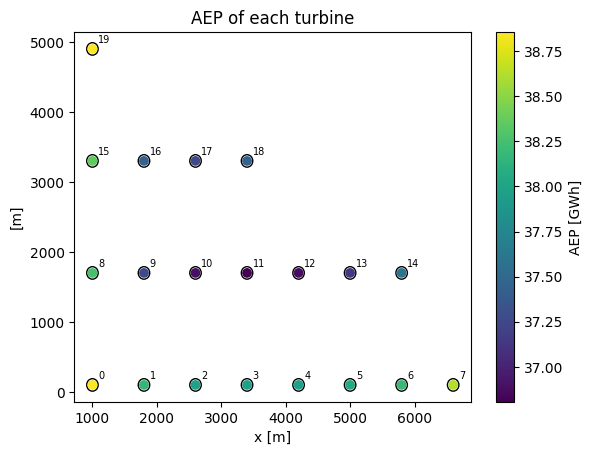

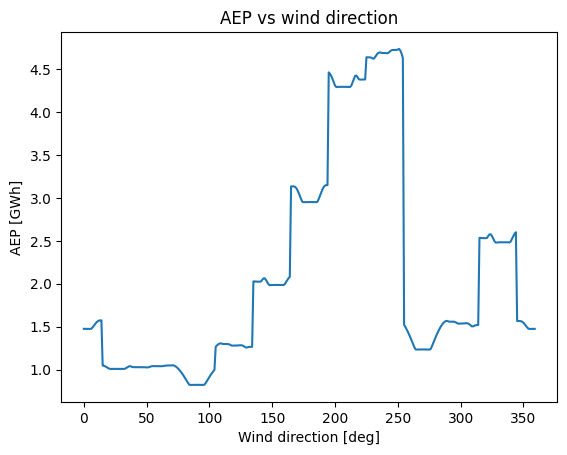

In [51]:
#Calculate AEP (Annual Energy Production)
from py_wake import NOJ

#import the wake deficit model
noj = NOJ(site,wt)
simulationResult = noj(wt_x,wt_y)

#Display Results
print ("Total AEP: %f GWh"%simulationResult.aep().sum())

plt.figure()
aep = simulationResult.aep() 
wt.plot(wt_x,wt_y)
c =plt.scatter(wt_x, wt_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

Text(0.5, 1.0, 'Wake map for 10 m/s and 225 deg')

<Figure size 640x480 with 0 Axes>

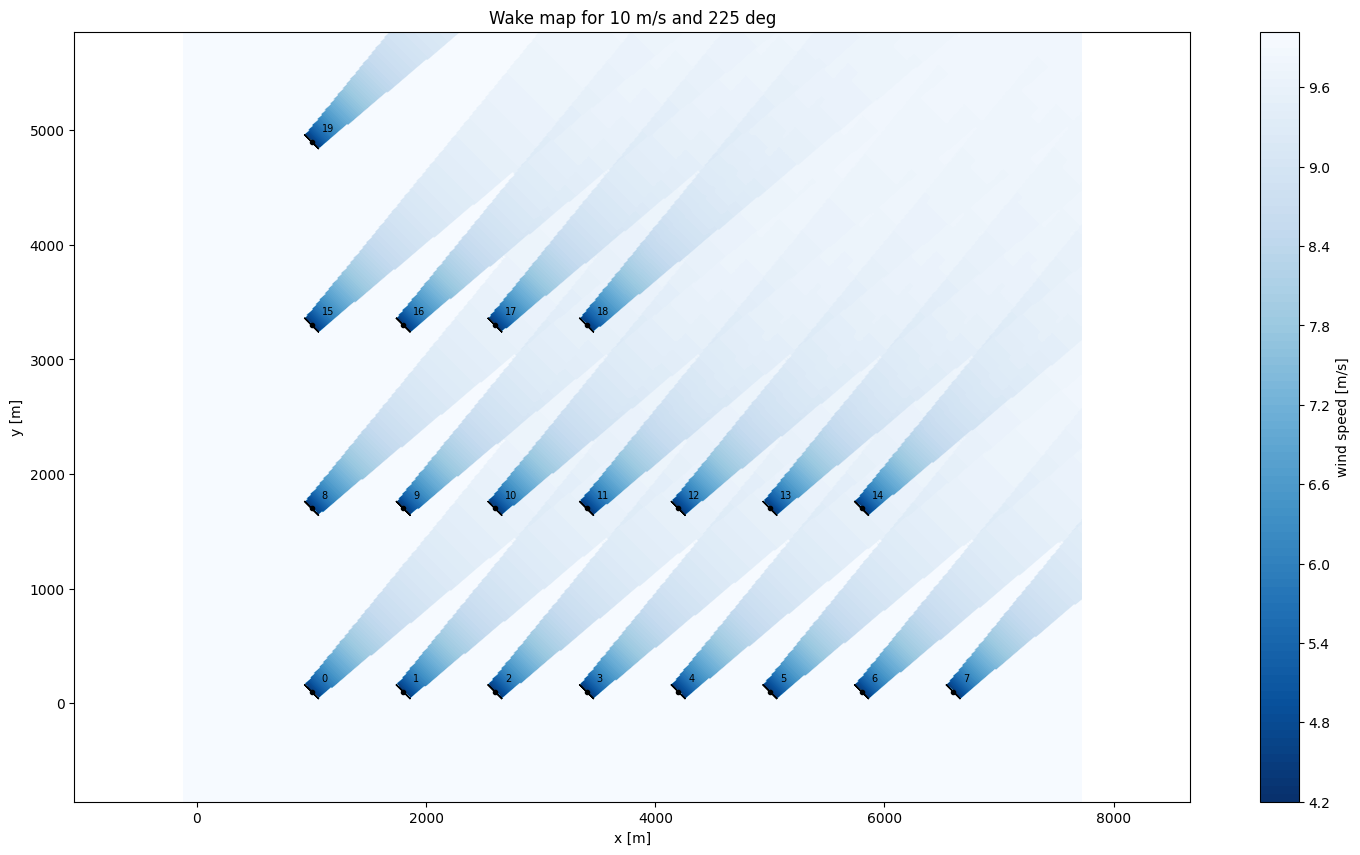

In [52]:
#Plot Flow Map
wind_speed = 10
wind_direction = 225

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

/home/andrew/repos/UniWork/WindFarm2/.venv/lib64/python3.10/site-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


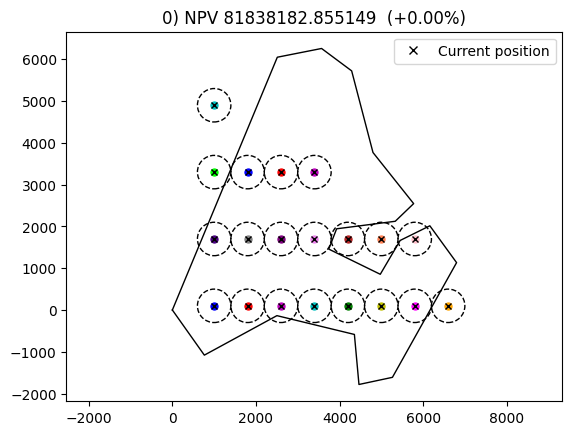

Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9332958.139872858
            Iterations: 249
            Function evaluations: 1336
            Gradient evaluations: 246
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
could not plot xs
could not plot ys


<Axes: >

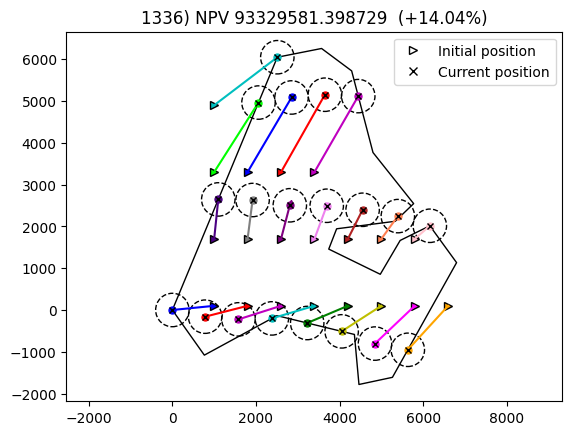

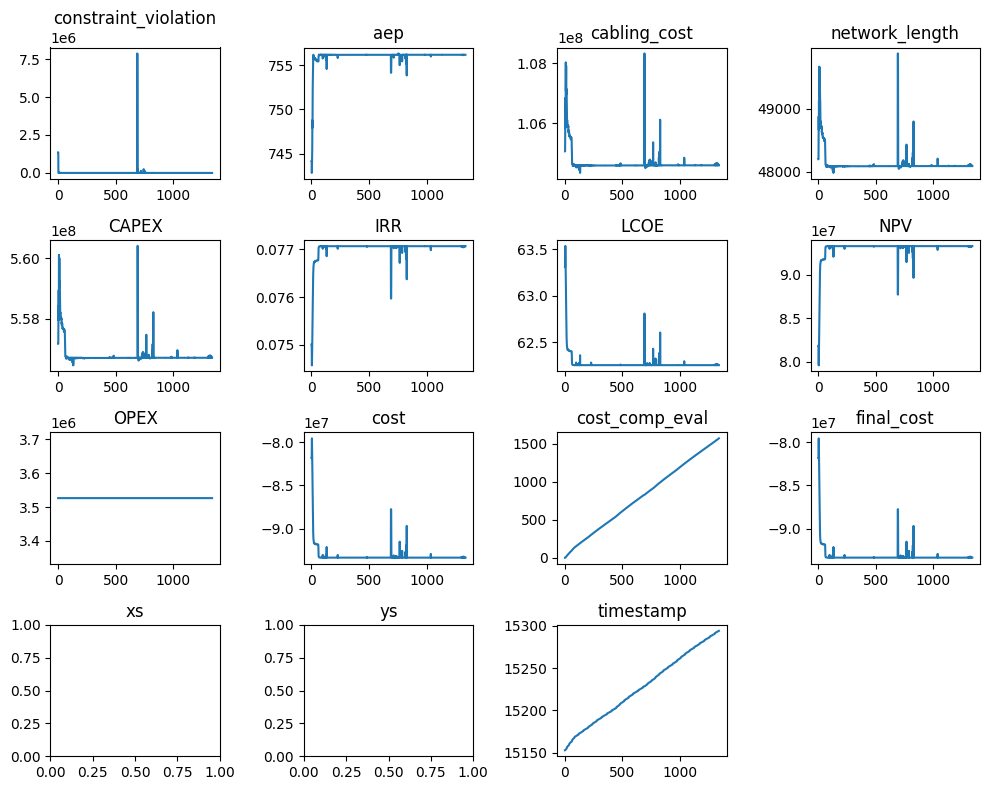

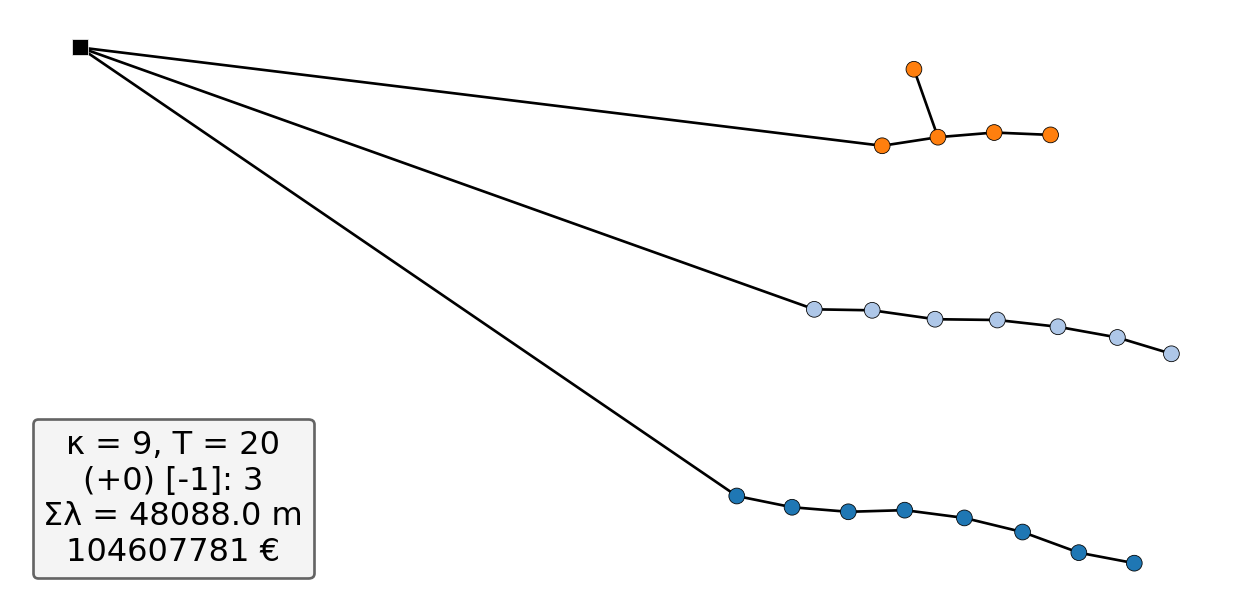

In [53]:
#Place and Optimise cables
#Source https://topfarm.pages.windenergy.dtu.dk/TopFarm2/notebooks/cables.html
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp, NoPlot
from topfarm.utils import plot_list_recorder
from topfarm.cost_models.electrical.optiwindnet_wrapper import WFNComponent

from py_wake.examples.data.iea37 import IEA37_WindTurbines
from py_wake import BastankhahGaussian
from py_wake.examples.data.hornsrev1 import Hornsrev1Site


from costmodels.finance import Depreciation, Technology, Product
from costmodels.project import Project
from costmodels.models import DTUOffshoreCostModel
from topfarm.examples.bathymetry_ficticio import (
    gaussian_surface,
    get_bathymetry_func_rect,
    plot_bathymetry_rect,
)

#Converstions between degrees on earth and m
def m2d_lat(m):
    return m / 111000

def m2d_lon(m, lat_deg):
    return m / (111000 * math.cos(math.radians(lat_deg)))

def d2m_lat(d):
    return d * 111000

def d2m_lon(d, lat_deg):
    return d * (111000 * math.cos(math.radians(lat_deg)))


# Inputs
plot = True
maxiter = 1000
sigma = 3000.0
# Here you set up cables [<number of turbines can be connected>, <price in € per meter>]
cables = np.array([(2, 2000), (9, 2200)])
LIFETIME = 25  # years
el_price = 71.91  # fixed ppa price Euro per MWh
driver = EasyScipyOptimizeDriver(maxiter=maxiter)

#Geometry
boundry_longLat = [
    (-2.066767,56.819881),
    (-2.025364,56.874380),
    (-2.007898,56.876265),
    (-1.996038,56.871434),
    (-1.987660,56.853835),
    (-1.971661,56.842818),
    (-1.978920,56.839010),
    (-2.002030,56.837389),
    (-2.005141,56.833013),
    (-1.984846,56.827582),
    (-1.976994,56.834877),
    (-1.965291,56.838037),
    (-1.954773,56.830095),
    (-1.980105,56.805366),
    (-1.993290,56.803825),
    (-1.995067,56.814611),
    (-2.025584,56.818665),
    (-2.054175,56.810151)
]

boundary = [[0] for _ in range(len(boundry_longLat))] # Pre-allocate space for boundry in m

for b in range(len(boundry_longLat)):
    relative_long = boundry_longLat[b][0] - boundry_longLat[0][0]
    boundary[b][0] = d2m_lon(relative_long, boundry_longLat[b][1])

    relative_lat = boundry_longLat[b][1] - boundry_longLat[0][1]
    boundary[b].append(d2m_lat(relative_lat))

#Split boundary into seperate x and y for plotting
bound_x = [p[0] for p in boundary] + [boundary[0][0]]
bound_y = [p[1] for p in boundary] + [boundary[0][1]]

boundary = np.asarray(boundary)

#Plot Boundary
plt.figure()
plt.plot(bound_x,bound_y,"m--")

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

#Define Turbine Positions
n_wt = len(wt_x)
turbines_pos=np.asarray([wt_x,wt_y]).T

#Define Substation position

shore_point_longLat = [(-2.220078, 56.877168)] #Shore point longatude, Latitude

shore_point_relative_long = shore_point_longLat[0][0] - boundry_longLat[0][0]
shore_point_relative_lat = shore_point_longLat[0][1] - boundry_longLat[0][1]



substations_pos = np.asarray(
    [[
        d2m_lon(shore_point_relative_long, boundry_longLat[0][1]),
        d2m_lat(shore_point_relative_lat),
    ]]
)

#windTurbines = wt (Already Defined)
#site = site (Site already defined)
wfm = BastankhahGaussian(site, wt)

#Water Depth

def water_depth_func(x, y, **kwargs):
    return np.full(len(x), 50.0)   # constant 50 m depth

#More detailed water depth is possible after more surveying
'''
g = gaussian_surface(sigma, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
if plot:
    plot_bathymetry_rect(g, x_min, x_max, y_min, y_max)
bathymetry_interpolator = get_bathymetry_func_rect(g, x_min, x_max, y_min, y_max)

def water_depth_func(x, y, **kwargs):
    xnew, ynew = np.meshgrid(x, y)
    points = np.array([xnew.flatten(), ynew.flatten()]).T
    return - np.diag(bathymetry_interpolator(points).reshape(n_wt, n_wt).T)
'''

#Econamy
Drotor_vector = [wt.diameter()] * n_wt
power_rated_vector = [float(wt.power(20)) * 1e-6] * n_wt
hub_height_vector = [wt.hub_height()] * n_wt
simres = wfm(wt_x, wt_y)
aep_ref = simres.aep().values.sum()
RP_MW = wt.power(20) * 1e-6
CF_ref = aep_ref * 1e3 / (RP_MW * 24 * 365 * n_wt)

cost_model = DTUOffshoreCostModel(
    rated_power=wt.power(20) / 1e6,
    rotor_speed=10.0,
    rotor_diameter=wt.diameter(),
    hub_height=wt.hub_height(),
    lifetime=LIFETIME,
    capacity_factor=CF_ref,
    nwt=n_wt,
    profit=0,
)

wind_plant = Technology(
    name="wind",
    lifetime=LIFETIME,
    product=Product.SPOT_ELECTRICITY,
    opex=12600 * n_wt * RP_MW + 1.35 * aep_ref * 1000,  # Euro
    wacc=0.06,
    cost_model=cost_model,
)

project = Project(
    technologies=[wind_plant],
    product_prices={Product.SPOT_ELECTRICITY: el_price},
    depreciation=Depreciation(rate=(0, 1), year=(0, LIFETIME)),
)


def economic_func(aep, water_depth, cabling_cost, **kwargs):
    aep_scaled = aep * 10**3
    npv, aux = project.npv(
        productions={wind_plant.name: aep_scaled},
        cost_model_args={
            wind_plant.name: {"water_depth": water_depth, "aep": aep_scaled}
        },
        finance_args={"shared_capex": cabling_cost},
        return_aux=True,
    )
    return npv, {
        "LCOE": aux["LCOE"][0],
        "IRR": aux["IRR"],
        "CAPEX": aux["CAPEX"],
        "OPEX": np.mean(aux["OPEX"]),
    }


def economic_func_grad(aep, water_depth, cabling_cost, **kwargs):
    aep_scaled = aep * 10**3
    grad = project.npv_grad(
        productions={wind_plant.name: aep_scaled},
        cost_model_args={
            wind_plant.name: {"water_depth": water_depth, "aep": aep_scaled}
        },
        finance_args={"shared_capex": cabling_cost},
    )
    return (
        grad[0][wind_plant.name] * 1e3,  # dNPV/dAEP | because of AEP scaling at the top
        grad[1][wind_plant.name]["water_depth"],  # dNPV/dWaterDepth
        grad[2]["shared_capex"],  # dNPV/dCablingCost
    )

#Components
aep_comp = PyWakeAEPCostModelComponent(wfm, n_wt, objective=False, output_key="aep")

water_depth_component = CostModelComponent(
    input_keys=[("x", np.zeros(n_wt)), ("y", np.zeros(n_wt))],
    n_wt=n_wt,
    cost_function=water_depth_func,
    objective=False,
    output_keys=[("water_depth", np.zeros(n_wt))],
)


cable_component = WFNComponent(turbines_pos, substations_pos, cables)

npv_comp = CostModelComponent(
    input_keys=[("aep", 0), ("water_depth", np.zeros(n_wt)), ("cabling_cost", 0)],
    n_wt=n_wt,
    cost_function=economic_func,
    cost_gradient_function=economic_func_grad,
    output_keys=[("NPV", 0)],
    additional_output=[
        ("LCOE", 0),
        ("IRR", 0),
        ("CAPEX", 0),
        ("OPEX", 0),
        # ('LCOE_ref', 0)
    ],
    maximize=True,
    objective=True,
)

cost_comp = TopFarmGroup([aep_comp, water_depth_component, cable_component, npv_comp])

# Problem Assembly
if plot:
    plot_comp = XYPlotComp()
else:
    plot_comp = NoPlot()

tf = TopFarmProblem(
    design_vars={'x': wt_x, 'y': wt_y},
    cost_comp=cost_comp,
    constraints=[XYBoundaryConstraint(boundary, boundary_type='polygon'),SpacingConstraint(diameter*4)],
    driver=driver,
    plot_comp=plot_comp,
    expected_cost=1e1,
)


#Smart Start
'''
x = np.linspace(x_min, x_max, 1000)
y = np.linspace(y_min, y_max, 1000)
YY, XX = np.meshgrid(y, x)
tf.smart_start(
    XX, YY, tf.cost_comp.comp_0.get_aep4smart_start(ws=10, wd=220), random_pct=20
)
tf.evaluate()
'''
#Optimise
cost, state, recorder = tf.optimize()

#Plot
plot_list_recorder(recorder, dont_plot=["v0", "v1"])
tf.model.cost_comp.comp_2.wfn.plot()



Turbine Locations in M
[[5.239519121608858e-10, 6.27959718834789e-10], [783.9462934024998, -159.4688815356353], [1581.334427886683, -224.06175878342472], [2380.9948569624275, -200.73375303012077], [3226.7559588751224, -310.89112630710025], [4051.4421454343023, -511.0165398201275], [4848.952198070402, -803.2068947462802], [5634.926505117486, -952.3551381772703], [1098.6323231462613, 2646.2910520069604], [1919.609033156799, 2632.273266226652], [2810.7138403815243, 2506.007450695396], [3693.9615235443853, 2494.8000274647543], [4553.0408439704715, 2398.863353619196], [5395.559925607381, 2247.085670029547], [6161.364981282581, 2015.6906087170096], [2061.131852432741, 4964.677138277836], [2851.8480859452716, 5086.245236158297], [3649.1250928511654, 5152.2269168988405], [4448.426189397168, 5118.749821454187], [2511.4601219013744, 6049.394593832273]]
Turbine Locations in degrees
[[56.81988100000001, 2.0667670000000085], [56.81844434340959, 2.079671547523679], [56.817862425596545, 2.09279695704

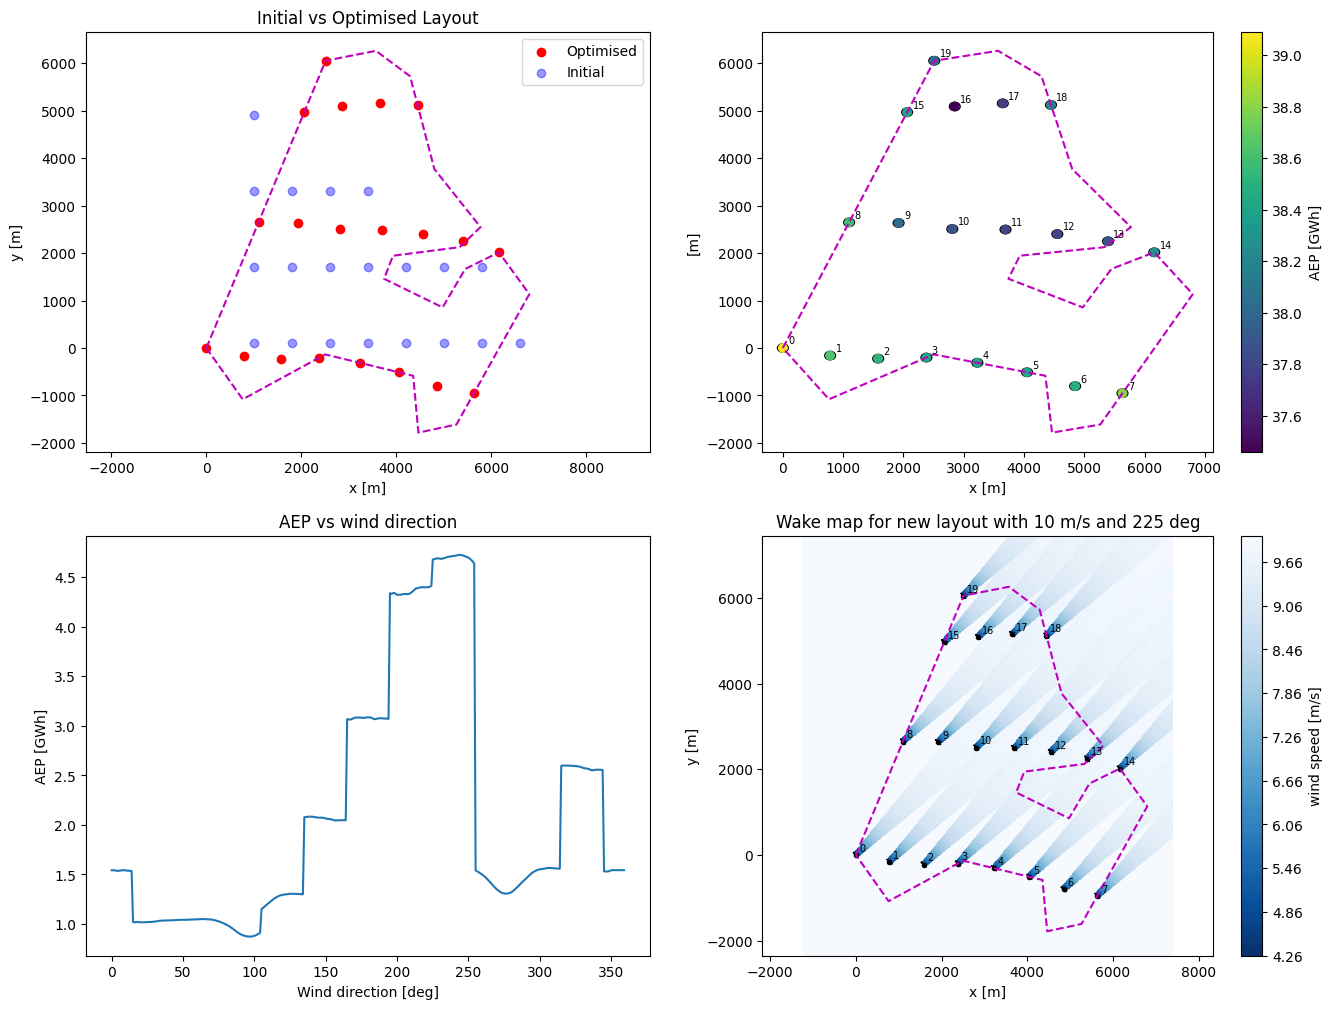

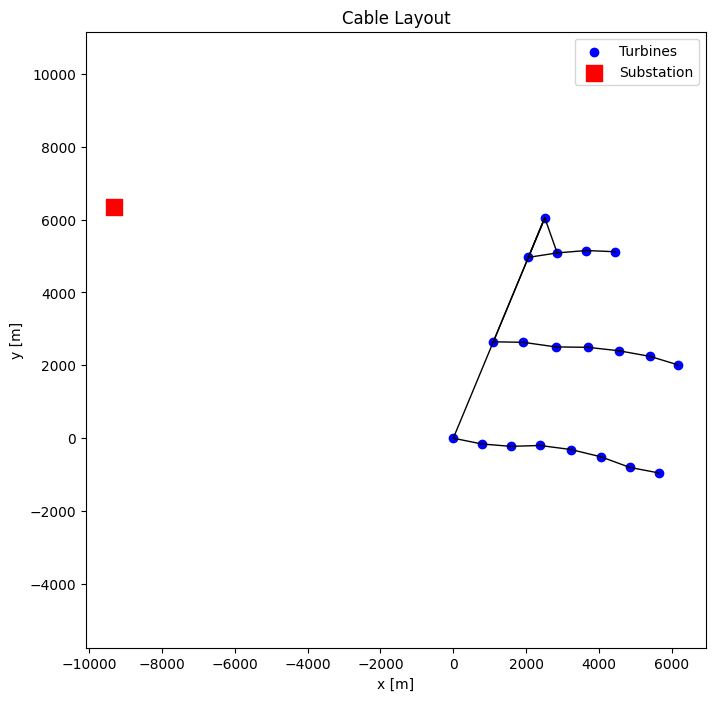

In [54]:

#Define Engineering windfarm model for new layout
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModelNew = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

#import the wake deficit model
noj = NOJ(site,wt)
newSimulationResult = noj(x=state['x'],y=state['y'])

#Get coordinates of new locations and format into list
wt_x_locations=state['x']
wt_y_locations=state['y']
wt_xy_locations = [[0] for _ in range(len(wt_x_locations))] # Pre-allocate space for turbine locations in m

#Get new turbine locations in M
for l in range(len(wt_x_locations)):
    wt_xy_locations[l][0] = float(wt_x_locations[l])
    wt_xy_locations[l].append(float(wt_y_locations[l]))

print("Turbine Locations in M")
print(wt_xy_locations)

#Convert locations to lat and long
wt_lat_long_new = [[0] for _ in range(len(wt_x_locations))]
for t in range(len(wt_lat_long_new)):
    wt_lat_long_new[t][0] = m2d_lat(wt_xy_locations[t][1]) + boundry_longLat[0][1]
    wt_lat_long_new[t].append(m2d_lon(wt_xy_locations[t][0],wt_lat_long_new[t][0]) + boundry_longLat[0][0] * (-1))

print("Turbine Locations in degrees")
print(wt_lat_long_new)

#Display Results for new simulation
print("Total AEP: %f GWh"%newSimulationResult.aep().sum())

# Plot results
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.scatter(state['x'], state['y'], c='red', label='Optimised')
plt.scatter(wt_x, wt_y, c='blue', alpha=0.4, label='Initial')
plt.plot(bound_x, bound_y, 'm--')
plt.legend()
plt.title("Initial vs Optimised Layout")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")

#Plot AEP of Turbines
plt.subplot(2,2,2)
aep = newSimulationResult.aep() 
wt.plot(x=state['x'],y=state['y'])
plt.plot(bound_x, bound_y, 'm--')
c =plt.scatter(x=state['x'],y=state['y'], c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.xlabel('x [m]')
plt.ylabel('[m]')

#Plot AEP vs Wind direction
plt.subplot(2,2,3)
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

#Plot Flow Map for new layout
plt.subplot(2,2,4)
flow_map_new = newSimulationResult.flow_map(ws=wind_speed, wd=wind_direction)
flow_map_new.plot_wake_map()
plt.plot(bound_x, bound_y, 'm--')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for new layout with' + f' {wind_speed} m/s and {wind_direction} deg')
plotName = "Turbine Plot " + str(num_turb_per_row)
plt.savefig("Plots/"+plotName)











wfn = tf.model.cost_comp.comp_2.wfn

# Final turbine positions
turb_x = state['x']
turb_y = state['y']
n = len(turb_x)

# Substation positions
sub_x = substations_pos[:,0]
sub_y = substations_pos[:,1]

plt.figure(figsize=(8,8))

# Plot turbines
plt.scatter(turb_x, turb_y, c='blue', label='Turbines')

# Plot substations
plt.scatter(sub_x, sub_y, c='red', marker='s', s=120, label='Substation')

# Plot cables from the NetworkX graph
for i, j in wfn.G.edges():
    # Node i
    if i < n:
        x1, y1 = turb_x[i], turb_y[i]
    else:
        x1, y1 = sub_x[i - n], sub_y[i - n]

    # Node j
    if j < n:
        x2, y2 = turb_x[j], turb_y[j]
    else:
        x2, y2 = sub_x[j - n], sub_y[j - n]

    plt.plot([x1, x2], [y1, y2], 'k-', linewidth=1)

plt.legend()
plt.title("Cable Layout")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.show()

